In [ ]:
# Get METAR data in bulk
%run auto_request_data.py

In [172]:
# Parse relevant METAR data into CSV
%run parse_to_csv.py RCTP

RCTP


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


In [47]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

In [174]:
airport = "RCTP"

train_df = pd.read_csv(airport + "/" + airport + "_train.csv")
test_df = pd.read_csv(airport + "/" + airport + "_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

print(train_df)

       windSpdKts  gustKts  windVrbDeg  intensity  rain  visibilityMtrs   qnh  \
3032           18        0          60       0.00     0            9999  1024   
32679          11        0           0       0.00     0            9999  1023   
39332          13        0           0       0.00     0            9999  1002   
20571          16        0           0       0.00     0            9999  1019   
34804          13        0           0       0.00     0            9999  1015   
...           ...      ...         ...        ...   ...             ...   ...   
32815          25        0           0       0.00     0            9999  1028   
23083          13        0           0       0.00     0            9999  1023   
26152           7        0          60       0.00     0            9999  1006   
18903           2        0           0       0.00     0            9999  1016   
35213          12        0           0       0.00     0            9999  1017   

       ws  
3032    0  
326

In [175]:
train_df_norm = train_df.copy()
test_df_norm = test_df.copy()

# Scale down wind speed
train_df_norm["windSpdKts"] /= 50
test_df_norm["windSpdKts"] /= 50

# Scale down wind gust speed
train_df_norm["gustKts"] /= 50
test_df_norm["gustKts"] /= 50

# Scale down wind variability
train_df_norm["windVrbDeg"] /= 100
test_df_norm["windVrbDeg"] /= 100

# Scale down visibility
# train_df_norm["visibilityMtrs"] /= 10000
# test_df_norm["visibilityMtrs"] /= 10000

# Normalise, scale down QNH
train_df_norm["qnh"] -= 1013
train_df_norm["qnh"] /= 10
test_df_norm["qnh"] -= 1013
test_df_norm["qnh"] /= 10

print(train_df_norm)
print(test_df_norm)

       windSpdKts  gustKts  windVrbDeg  intensity  rain  visibilityMtrs   qnh  \
3032         0.36     0.00        0.60       0.00     0            9999  1.10   
32679        0.22     0.00        0.00       0.00     0            9999  1.00   
39332        0.26     0.00        0.00       0.00     0            9999 -1.10   
20571        0.32     0.00        0.00       0.00     0            9999  0.60   
34804        0.26     0.00        0.00       0.00     0            9999  0.20   
...           ...      ...         ...        ...   ...             ...   ...   
32815        0.50     0.00        0.00       0.00     0            9999  1.50   
23083        0.26     0.00        0.00       0.00     0            9999  1.00   
26152        0.14     0.00        0.60       0.00     0            9999 -0.70   
18903        0.04     0.00        0.00       0.00     0            9999  0.30   
35213        0.24     0.00        0.00       0.00     0            9999  0.40   

       ws  
3032    0  
326

In [176]:
feature_columns = []

windSpdKts = tf.feature_column.numeric_column("windSpdKts")
feature_columns.append(windSpdKts)

gustKts = tf.feature_column.numeric_column("gustKts")
feature_columns.append(gustKts)

windVrbDeg = tf.feature_column.numeric_column("windVrbDeg")
feature_columns.append(windVrbDeg)

intensity = tf.feature_column.numeric_column("intensity")
feature_columns.append(intensity)

rain = tf.feature_column.numeric_column("rain")
feature_columns.append(rain)

vis_boundaries = list(np.arange(-1, 10000, 1000))
visibilityMtrs = tf.feature_column.numeric_column("visibilityMtrs")
visibilityMtrsBin = tf.feature_column.bucketized_column(visibilityMtrs, vis_boundaries)
feature_columns.append(visibilityMtrsBin)
# print(visibilityMtrsBin)

qnh = tf.feature_column.numeric_column("qnh")
feature_columns.append(qnh)

# Create a feature cross of windSpdKts and windVrbDeg
spd_x_vrb = tf.feature_column.crossed_column(["windSpdKts", "windVrbDeg"], hash_bucket_size=1000)
crossed_spd_vrb = tf.feature_column.indicator_column(spd_x_vrb)
feature_columns.append(crossed_spd_vrb)

# Create a feature cross of intensity and rain
int_x_rain = tf.feature_column.crossed_column(["intensity", "rain"], hash_bucket_size=50)
crossed_int_rain = tf.feature_column.indicator_column(int_x_rain)
feature_columns.append(crossed_int_rain)

feature_layer = layers.DenseFeatures(feature_columns)

# np.set_printoptions(threshold=False)
# print(train_df_norm[train_df_norm.visibilityMtrs == train_df_norm.visibilityMtrs.min()])
# print(feature_layer(dict(train_df_norm)))

In [177]:
def neural_model(my_learning_rate, feature_layer, my_metrics):
    """Create and compile a simple classification model."""
    model = tf.keras.models.Sequential()
    
    model.add(feature_layer)

    # Funnel the regression value through a ReLU function.
    model.add(tf.keras.layers.Dense(units=30, activation='relu', name="hidden1",
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)))
    
    model.add(tf.keras.layers.Dense(units=10, activation='relu', name="hidden2",
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)))
    
    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1, name='Output', activation='sigmoid'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=my_metrics)

    return model


def linear_model(my_learning_rate, feature_layer, my_metrics):
    """Create and compile a simple classification model."""
    model = tf.keras.models.Sequential()
    
    model.add(feature_layer)

    # Funnel the regression value through a ReLU function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(20,), activation='sigmoid'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=my_metrics)

    return model   


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True, validation_split=0.2):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays, where
    # each array contains the data for one feature.  Here, we're passing
    # every column in the dataset. Note that the feature_layer will filter
    # away most of those columns, leaving only the desired columns and their
    # representations as features.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name)) 
    history = model.fit(x=features, y=label, batch_size=batch_size,
                          epochs=epochs, shuffle=shuffle, validation_split=validation_split)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [178]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""   

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/20
328/328 [==============================] - 2s 3ms/step - loss: 0.3816 - accuracy: 0.8459 - precision: 0.0897 - recall: 0.0622 - roc-auc: 0.5719 - pr-auc: 0.1077 - val_loss: 0.2872 - val_accuracy: 0.9023 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.8022 - val_pr-auc: 0.3308
Epoch 2/20
328/328 [==============================] - 1s 2ms/step - loss: 0.2696 - accuracy: 0.9055 - precision: 0.8254 - recall: 0.0485 - roc-auc: 0.8279 - pr-auc: 0.3997 - val_loss: 0.2513 - val_accuracy: 0.9104 - val_precision: 0.7030 - val_recall: 0.1450 - val_roc-auc: 0.8631 - val_pr-auc: 0.4568
Epoch 3/20
328/328 [==============================] - 1s 2ms/step - loss: 0.2407 - accuracy: 0.9119 - precision: 0.6736 - recall: 0.2002 - roc-auc: 0.8691 - pr-auc: 0.4751 - val_loss: 0.2292 - val_accuracy: 0.9106 - val_precision: 0.6308 - val_recall: 0.2050 - val_roc-auc: 0.8858 - val_pr-auc: 0.5052
Epoch 4/20
328/328 [==============================] - 1s 2ms/step - loss: 0.2225 - acc

103/103 [==============================] - 0s 1ms/step - loss: 0.2012 - accuracy: 0.9185 - precision: 0.6489 - recall: 0.3931 - roc-auc: 0.9082 - pr-auc: 0.5732
[0.20117489993572235, 0.9185264706611633, 0.6488673090934753, 0.39313724637031555, 0.9081734418869019, 0.5732071995735168]


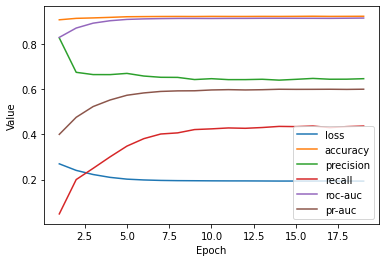

In [183]:
learning_rate = 0.0005
epochs = 20
batch_size = 100
label_name = "ws"
classification_threshold = 0.45
validation_split = 0.2

# Establish the metrics the model will measure.
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),
    tf.keras.metrics.AUC(num_thresholds=100, name='roc-auc'),
    tf.keras.metrics.AUC(num_thresholds=100, name='pr-auc', curve='PR')
]

# Establish the model's topography.
my_model = neural_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size, validation_split=validation_split)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['loss', 'accuracy', 'precision', 'recall', 'roc-auc', 'pr-auc']

plot_curve(epochs, hist, list_of_metrics_to_plot)

x_test = {name: np.array(value) for name, value in test_df_norm.items()}
y_test = np.array(x_test.pop(label_name))

results = my_model.evaluate(x_test, y_test, batch_size=batch_size)
print(results)